In [1]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import h5py as h5

from scipy import ndimage
from scipy.stats import chisquare, power_divergence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize

%matplotlib inline

In [2]:
depth = pd.read_csv(r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\data\flow_01_WellCombinedData.csv', skiprows=6)

perforations = pd.read_csv(r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\data\perforations.csv')
perforations['MD'] = ((perforations['TD'] + perforations['BD']) / 2) / 3.28084

perforations.index = np.searchsorted(depth['Measured Depth (mKB)'], perforations['MD'].values)
merged = pd.merge(left=depth, right=perforations, left_index=True, right_index=True, how='left')

pstring = ["P{0}-{1}".format(x, y) for x, y in zip(merged['Stage'].values, merged['Cluster'].values)]
merged['Pstring'] = pstring

merged['Clusters_per_stage'] = 0

for i, group in merged.groupby('Stage'):
    merged.loc[group.index, 'Clusters_per_stage'] = group['Cluster'].max()

merged.head()

,Channel Number,Optical Distance,Measured Depth (mKB),UTM - N,UTM - E,True Vertical Depth (mKB),Stage,Cluster,TD,BD,Shots,MD,Pstring,Clusters_per_stage
0,0,0.5,3.4,0.0,0.0,3.4,NaN,NaN,NaN,NaN,NaN,NaN,Pnan-nan,0.0
1,1,1.5,4.4,0.0,0.0,4.4,NaN,NaN,NaN,NaN,NaN,NaN,Pnan-nan,0.0
2,2,2.5,5.4,0.0,0.0,5.4,NaN,NaN,NaN,NaN,NaN,NaN,Pnan-nan,0.0
3,3,3.5,6.4,0.0,0.0,6.4,NaN,NaN,NaN,NaN,NaN,NaN,Pnan-nan,0.0
4,4,4.5,7.4,0.0,0.0,7.4,NaN,NaN,NaN,NaN,NaN,NaN,Pnan-nan,0.0


In [3]:
depth.shape

(6500, 6)

In [4]:
fbe_file = h5.File(r'C:\Users\george.crowther\Dropbox (OptaSense OFS)\Customer Projects\Rice Energy\Belmont Project\Flow_Project\Output\FBE_Export_2017-02-20_10_35_55_00\fbe_1.000s_2016-04-21T085949Z.h5', 'r')

In [5]:
fdata = [fbe_file['/Acquisition/Processed/Fbe[1]/FbeData[{0}]'.format(n)] for n in range(5)]
starttime = pd.to_datetime(fbe_file['/Acquisition/Processed/Fbe[1]/FbeDataTime'].value[0] * 1000)
endtime = pd.to_datetime(fbe_file['/Acquisition/Processed/Fbe[1]/FbeDataTime'].value[-1] * 1000)
print(starttime, endtime)

2016-04-21 08:59:49 2016-05-17 18:00:14


In [6]:
fdata_frames = []
for data in fdata:
    temp_frame = pd.DataFrame(data = data.value, index = pd.to_datetime(pd.to_datetime(fbe_file['/Acquisition/Processed/Fbe[1]/FbeDataTime'].value * 1000)))
    fdata_frames.append(temp_frame.resample('1H').median())
    temp_frame = None

KeyboardInterrupt: 

In [ ]:
for i, frame in enumerate(fdata_frames):
    frame.to_pickle(r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\data\med_filtered\med_filt_1H_B{0}'.format(i))

In [7]:
# Running this if loading from the pickled files
import os
input_dir = r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\data\med_filtered'
fdata_frames = [pd.read_pickle(os.path.join(input_dir, f)) for f in os.listdir(input_dir)]

C:\Users\george.crowther\AppData\Local\Continuum\Anaconda3_4\envs\rice_energy\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()


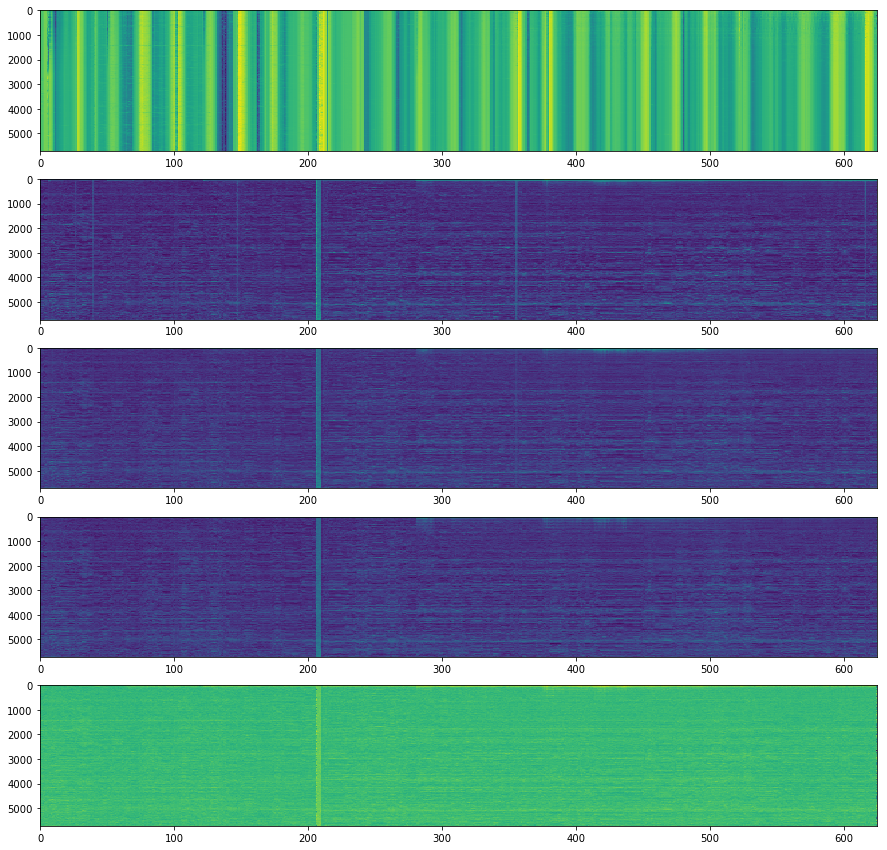

In [8]:
f, ax = plt.subplots(5, 1, figsize = (15, 15))
for a in range(5):
    ax[a].imshow(10*np.log10(fdata_frames[a].iloc[:, :5716].loc[(fdata_frames[1] < 1).any(axis=1)].T), aspect = 'auto', cmap = 'viridis')
plt.show()

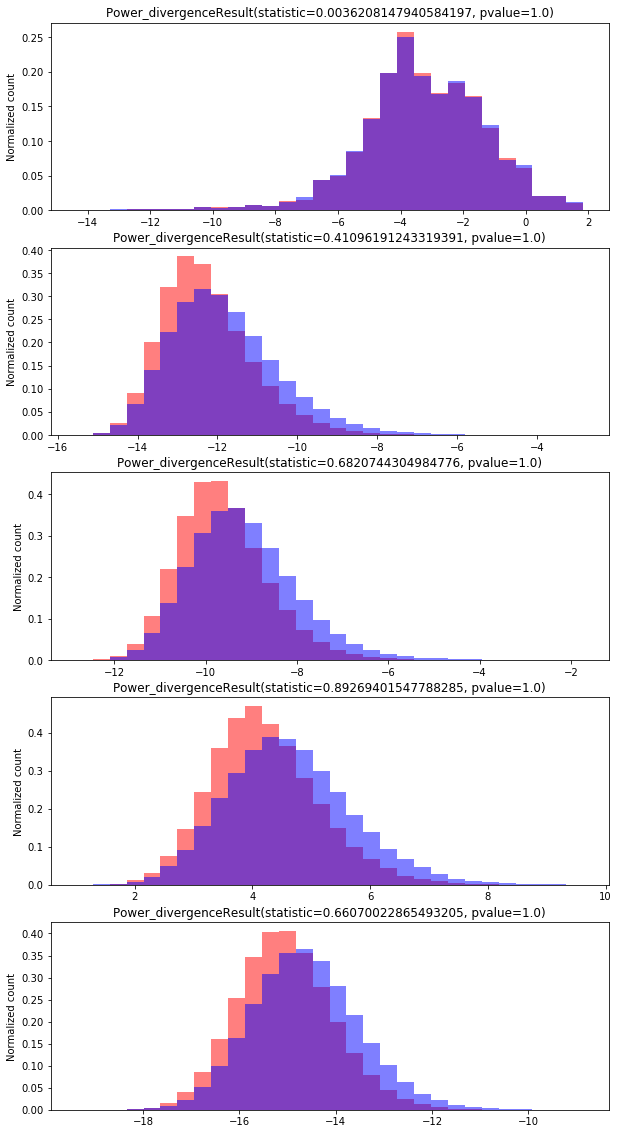

In [9]:
top_of_res = 2835
bottom_of_res = 5720
top_of_noise = 1000

f, ax = plt.subplots(5, 1, figsize = (10, 20))

start_sample = 0
end_sample = -1

for i in range(5):
    
    null_data = fdata_frames[i].loc['29-04-2016 18:00:00': '30-April-2016 12:00:00']
    data = fdata_frames[i].iloc[1:-1, :5716].loc[(fdata_frames[i] < 1).any(axis=1)]

    data = data.loc[~data.index.isin(null_data.index)]
    
    noise = data.iloc[start_sample:end_sample, top_of_noise:top_of_res].as_matrix().flatten()
    signal = data.iloc[start_sample:end_sample, top_of_res:bottom_of_res].as_matrix().flatten()

    hist, bins, patches = ax[i].hist(np.nan_to_num(10*np.log10(noise)), bins = 30, alpha = 0.5, normed=True, color = 'red')
    ax[i].set_ylabel('Normalized count')
    #ax[i].set_xlabel('Amplitude (dB)')
    mhist, mbins, mpathces = ax[i].hist(np.nan_to_num(10*np.log10(signal)), bins = bins, alpha = 0.5, normed=True, color = 'blue')
    ax[i].set_title(chisquare(mhist, f_exp = hist))

plt.show()

C:\Users\george.crowther\AppData\Local\Continuum\Anaconda3_4\envs\rice_energy\lib\site-packages\scipy\stats\stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


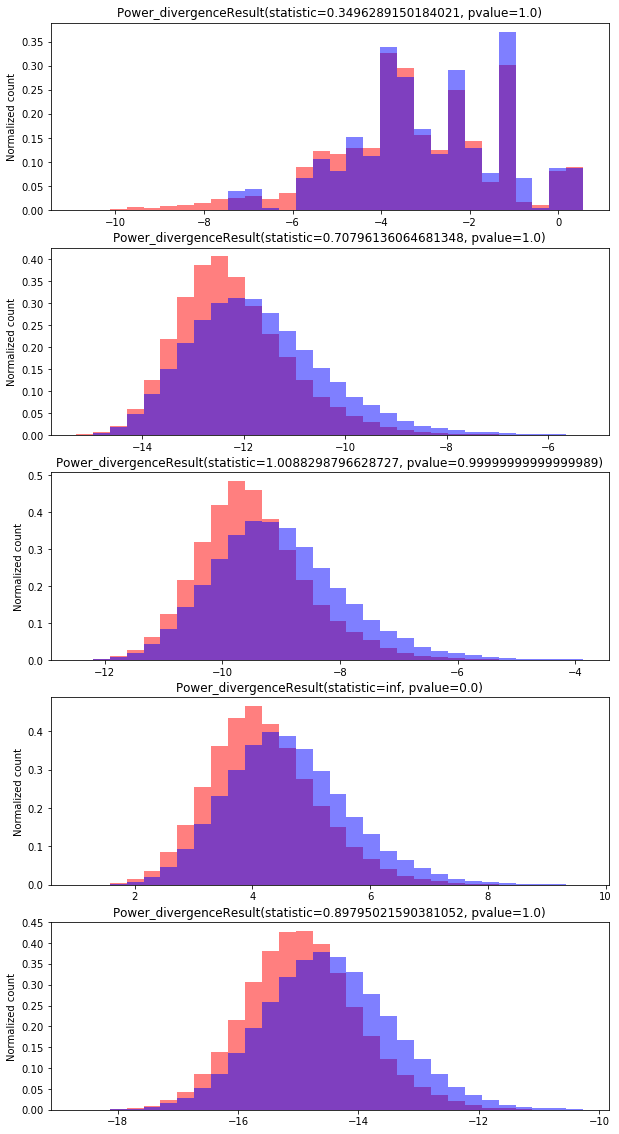

In [10]:
top_of_res = 2835
bottom_of_res = 5720
top_of_noise = 1000

f, ax = plt.subplots(5, 1, figsize = (10, 20))

start_sample = 0
end_sample = 30

for i in range(5):
    
    null_data = fdata_frames[i].loc['29-04-2016 18:00:00': '30-April-2016 12:00:00']
    data = fdata_frames[i].iloc[1:-1, :5716].loc[(fdata_frames[i] < 1).any(axis=1)]

    data = data.loc[~data.index.isin(null_data.index)]
    
    noise = data.iloc[start_sample:end_sample, top_of_noise:top_of_res].as_matrix().flatten()
    signal = data.iloc[start_sample:end_sample, top_of_res:bottom_of_res].as_matrix().flatten()

    hist, bins, patches = ax[i].hist(np.nan_to_num(10*np.log10(noise)), bins = 30, alpha = 0.5, normed=True, color = 'red')
    ax[i].set_ylabel('Normalized count')
    #ax[i].set_xlabel('Amplitude (dB)')
    mhist, mbins, mpathces = ax[i].hist(np.nan_to_num(10*np.log10(signal)), bins = bins, alpha = 0.5, normed=True, color = 'blue')
    ax[i].set_title(chisquare(mhist, f_exp = hist))

plt.show()    

In [11]:
def calculate_chi_squared(data, noise_start, noise_stop, signal_start, signal_stop, bins = 20):
    
    noise = data[:, noise_start:noise_stop].flatten()
    nhist, nbins = np.histogram(noise, normed = True, bins = bins)
    
    result = np.zeros(signal_stop - signal_start)
    
    for i in np.arange(result.shape[0]):
        signal = data[:, signal_start + i]
        shist, sbins = np.histogram(signal, normed = True, bins = nbins)
        
        result[i] = chisquare(nhist, shist)[0]
        
    return result

def roll_chi_squared(data, window, noise_start, noise_stop, signal_start, signal_stop, bins = 20):
    
    result = np.zeros((data.shape[0] - window + 1, signal_stop - signal_start))
    
    for i in np.arange(result.shape[0]):
        input_step = data[i:i+window, :]
        
        result[i] = calculate_chi_squared(input_step, noise_start, noise_stop, signal_start, signal_stop, bins = bins)
    
    return result    

C:\Users\george.crowther\AppData\Local\Continuum\Anaconda3_4\envs\rice_energy\lib\site-packages\scipy\stats\stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


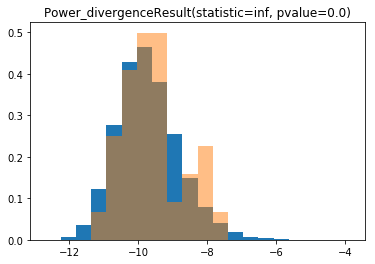

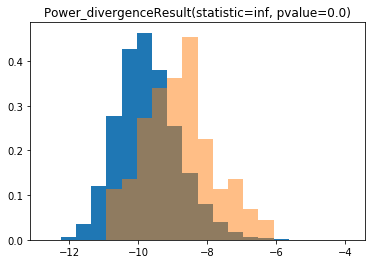

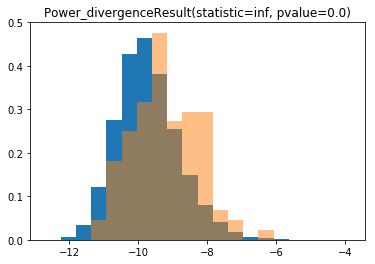

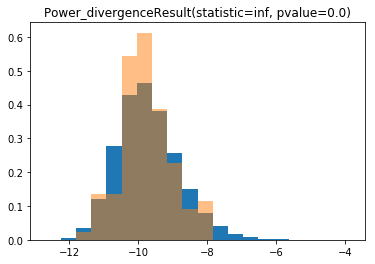

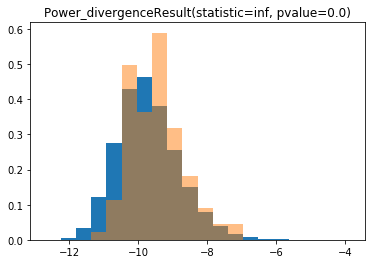

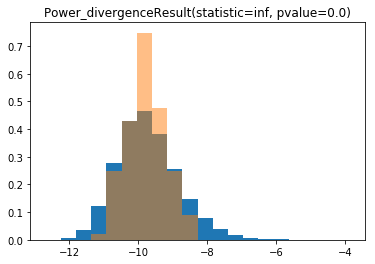

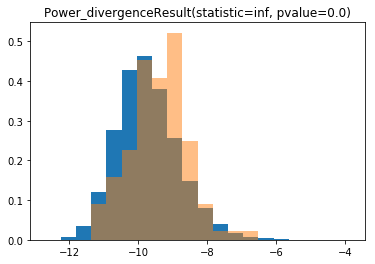

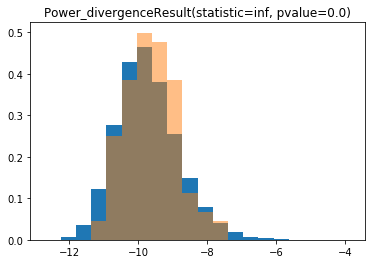

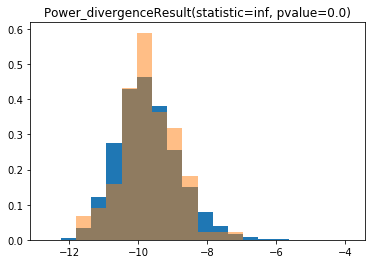

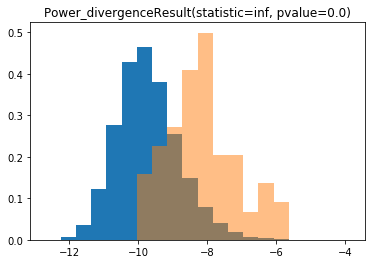

In [12]:
i = 2
null_data = fdata_frames[i].loc['29-04-2016 18:00:00': '30-April-2016 12:00:00']
data = fdata_frames[i].iloc[1:-1, :5716].loc[(fdata_frames[i] < 1).any(axis=1)]

data = data.loc[~data.index.isin(null_data.index)].as_matrix()


noise = 10*np.log10(data[:100, 1000:2835])

result = np.arange(1000, dtype = 'float')
p = np.arange(1000, dtype = 'float')
for n in range(1000):
    signal = 10*np.log10(data[:100, 4000 + n])
    
    if n % 100 == 0:
        fig, ax = plt.subplots()
        hist, bins, patches = ax.hist(noise.flatten(), normed = True, bins = 20)
        shist, sbins, spatches = ax.hist(signal.flatten(), normed = True, bins = bins, alpha = 0.5)
        #shist[shist == 0.0] = hist.min()
        ax.set_title(chisquare(hist, shist))
        chi = chisquare(hist, shist)
        result[n] = chi[0]
        p[n] = chi[1]
        plt.show()
        
    else:
        hist, bins = np.histogram(noise.flatten(), normed = True, bins = 20)
        shist, sbins = np.histogram(signal.flatten(), normed = True, bins = bins)
        #shist[shist == 0.0] = hist.min()
        chi = chisquare(hist, shist)
        result[n] = chi[0]
        p[n] = chi[1]

#result = roll_chi_squared(10*np.log10(data[:60, :]), 50, 1000, 2835, 2836, 5716)



In [13]:
from scipy import stats

In [14]:
data.shape

(613, 5716)

In [15]:
import bokeh.plotting as bk
bk.output_notebook()
from bokeh.models import HoverTool, BoxZoomTool, WheelZoomTool, PanTool, ResetTool

Loading BokehJS ...

In [16]:
p = []
D = []
for channel in range(data.shape[1]):
    ks = stats.ks_2samp(noise.flatten(), 10*np.log10(data[:100, channel].flatten()))
    p.append(ks[1])
    D.append(ks[0])

In [17]:
TOOLS = [HoverTool(), BoxZoomTool(), WheelZoomTool(), PanTool(), ResetTool()]

fig = bk.figure(tools = TOOLS)
fig.scatter(p, D)

fig.xaxis.axis_label = "p-value"
fig.yaxis.axis_label = "K-S statistic"

bk.show(fig)

In [18]:
k_s_stat = pd.DataFrame(data = p, columns = ['p-value'])
k_s_stat['K-S stat'] = D

In [19]:
TOOLS = [HoverTool(), BoxZoomTool(), WheelZoomTool(), PanTool(), ResetTool()]
fig = bk.figure(tools = TOOLS, width = 900)
fig.line(k_s_stat.index, k_s_stat['K-S stat'], color = 'blue')
fig.line(k_s_stat.index, k_s_stat['p-value'], color = 'red')
bk.show(fig)

In [20]:
data[:, 3000].flatten()

array([ 0.12539849,  0.123289  ,  0.0924325 ,  0.081872  ,  0.106813  ,
        0.13324949,  0.109348  ,  0.1039925 ,  0.116345  ,  0.107423  ,
        0.0984775 ,  0.1098175 ,  0.096088  ,  0.09175751,  0.089027  ,
        0.0909085 ,  0.097084  ,  0.09630001,  0.088329  ,  0.0822825 ,
        0.0782355 ,  0.093134  ,  0.0852535 ,  0.0879265 ,  0.082168  ,
        0.0929235 ,  0.092137  ,  0.074726  ,  0.0736115 ,  0.083926  ,
        0.088953  ,  0.086862  ,  0.086844  ,  0.0945105 ,  0.086631  ,
        0.0825455 ,  0.079239  ,  0.078402  ,  0.088174  ,  0.1032415 ,
        0.0993385 ,  0.091772  ,  0.102475  ,  0.1022985 ,  0.108393  ,
        0.097907  ,  0.105985  ,  0.103873  ,  0.100159  ,  0.1224885 ,
        0.1262525 ,  0.089544  ,  0.12060601,  0.08174451,  0.090229  ,
        0.1237485 ,  0.127086  ,  0.13041651,  0.1151225 ,  0.095861  ,
        0.0909155 ,  0.084906  ,  0.125856  ,  0.09847049,  0.090063  ,
        0.1144255 ,  0.13209149,  0.1269815 ,  0.12292349,  0.10

C:\Users\george.crowther\AppData\Local\Continuum\Anaconda3_4\envs\rice_energy\lib\site-packages\scipy\stats\stats.py:4544: RuntimeWarning: divide by zero encountered in true_divide
  terms = (f_obs - f_exp)**2 / f_exp


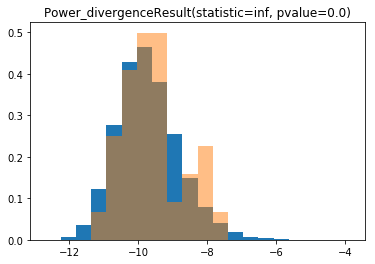

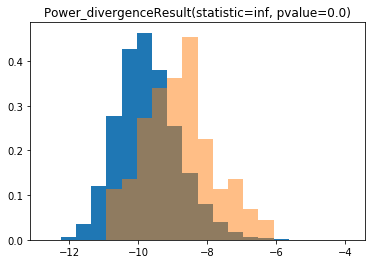

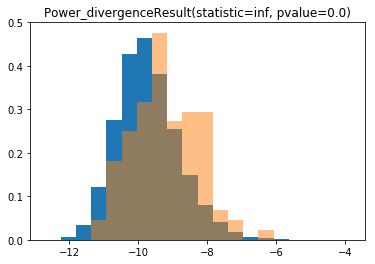

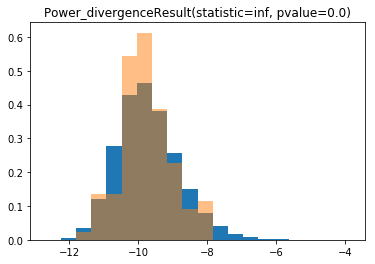

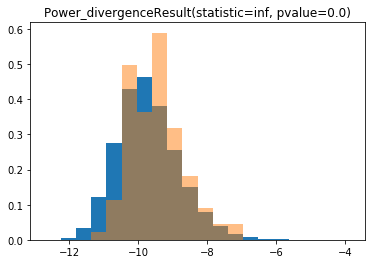

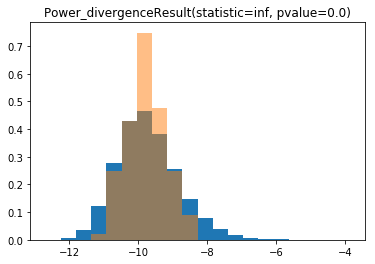

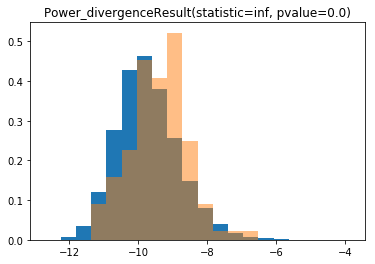

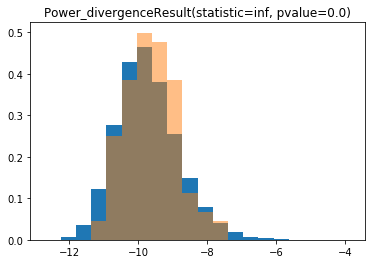

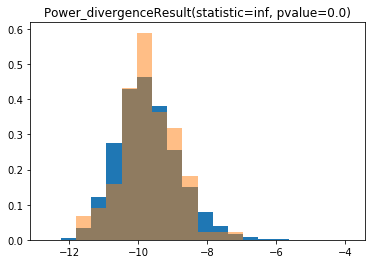

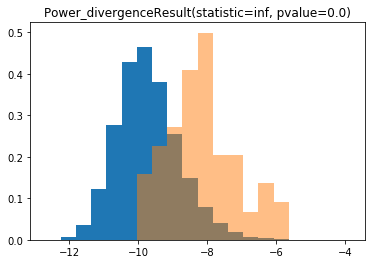

In [21]:
i = 2
null_data = fdata_frames[i].loc['29-04-2016 18:00:00': '30-April-2016 12:00:00']
data = fdata_frames[i].iloc[1:-1, :5716].loc[(fdata_frames[i] < 1).any(axis=1)]

data = data.loc[~data.index.isin(null_data.index)].as_matrix()


noise = 10*np.log10(data[:100, 1000:2835])

result = np.arange(1000, dtype = 'float')
p = np.arange(1000, dtype = 'float')
for n in range(1000):
    signal = 10*np.log10(data[:100, 4000 + n])
    
    if n % 100 == 0:
        fig, ax = plt.subplots()
        hist, bins, patches = ax.hist(noise.flatten(), normed = True, bins = 20)
        shist, sbins, spatches = ax.hist(signal.flatten(), normed = True, bins = bins, alpha = 0.5)
        #shist[shist == 0.0] = hist.min()
        ax.set_title(chisquare(hist, shist))
        chi = chisquare(hist, shist)
        result[n] = chi[0]
        p[n] = chi[1]
        plt.show()
        
    else:
        hist, bins = np.histogram(noise.flatten(), normed = True, bins = 20)
        shist, sbins = np.histogram(signal.flatten(), normed = True, bins = bins)
        #shist[shist == 0.0] = hist.min()
        chi = chisquare(hist, shist)
        result[n] = chi[0]
        p[n] = chi[1]

#result = roll_chi_squared(10*np.log10(data[:60, :]), 50, 1000, 2835, 2836, 5716)



In [22]:
fdata_frames[i].shape

(635, 6016)

In [23]:
50 % 3

2

In [24]:
noise

array([[ -9.81986427,  -9.64528275, -10.22816181, ...,  -8.7678566 ,
         -8.85545826,  -9.12534523],
       [ -9.63860416,  -9.83518219,  -8.08978176, ...,  -9.30505848,
         -9.30215454,  -9.35528946],
       [-10.06539536,  -9.99260139, -10.13058186, ...,  -9.56498241,
         -9.51985741,  -9.91180611],
       ..., 
       [ -9.34037685,  -9.41268539,  -9.70072651, ...,  -9.11070538,
         -8.86760426,  -9.85966873],
       [ -9.73951149, -10.29743767, -10.29836845, ..., -10.29060745,
        -10.46825218, -10.36566353],
       [-10.59376526, -10.6564045 , -10.76818275, ..., -10.06217861,
        -10.35971546, -10.7585001 ]], dtype=float32)

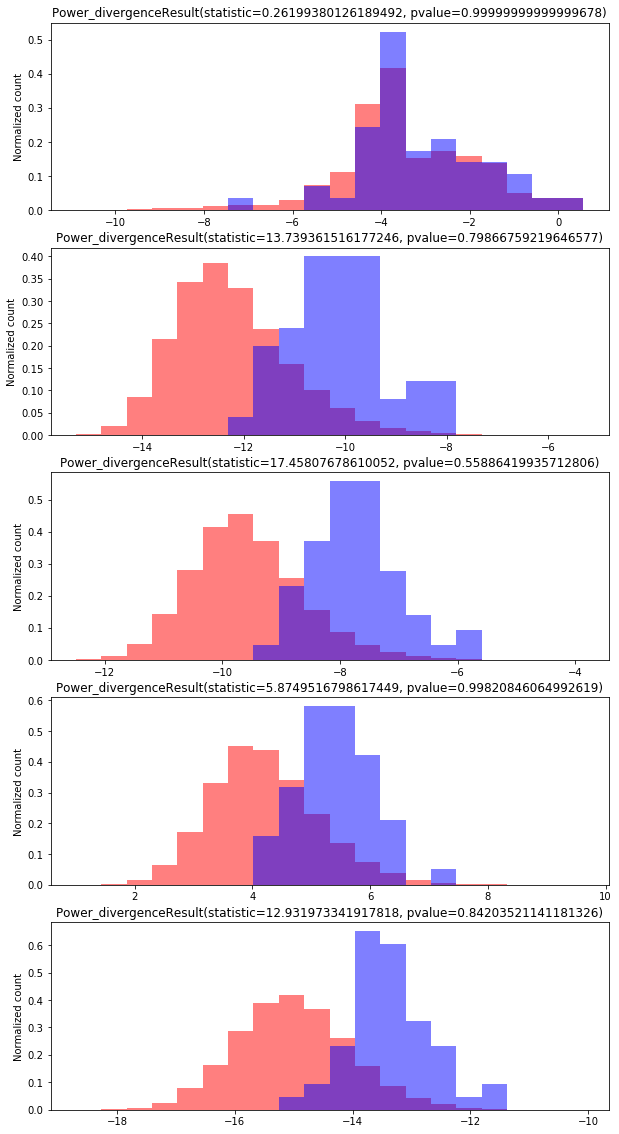

In [25]:
top_of_res = 2835
bottom_of_res = 5720
top_of_noise = 1000

f, ax = plt.subplots(5, 1, figsize = (10, 20))

start_sample = 0
end_sample = 50

for i in range(5):
    
    null_data = fdata_frames[i].loc['29-04-2016 18:00:00': '30-April-2016 12:00:00']
    data = fdata_frames[i].iloc[1:-1, :5716].loc[(fdata_frames[i] < 1).any(axis=1)]

    data = data.loc[~data.index.isin(null_data.index)]

    noise = data.iloc[start_sample:end_sample, top_of_noise:top_of_res].as_matrix().flatten()
    signal = data.iloc[start_sample:end_sample, 5000].as_matrix().flatten()

    hist, bins, patches = ax[i].hist(np.nan_to_num(10*np.log10(noise)), normed = True, bins = 20, alpha = 0.5, color = 'red')
    ax[i].set_ylabel('Normalized count')
    #ax[i].set_xlabel('Amplitude (dB)')
    mhist, mbins, mpathces = ax[i].hist(np.nan_to_num(10*np.log10(signal)), normed = True, bins = bins, alpha = 0.5, color = 'blue')
    ax[i].set_title(chisquare(mhist, f_exp = hist))

plt.show()  

In [26]:
mhist

array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.04644346,  0.09288691,
        0.23221729,  0.6502084 ,  0.60376495,  0.3251042 ,  0.23221729,
        0.04644346,  0.09288691,  0.        ,  0.        ,  0.        ])

In [27]:
f = pd.DataFrame(data = result)

In [28]:
result.ravel?

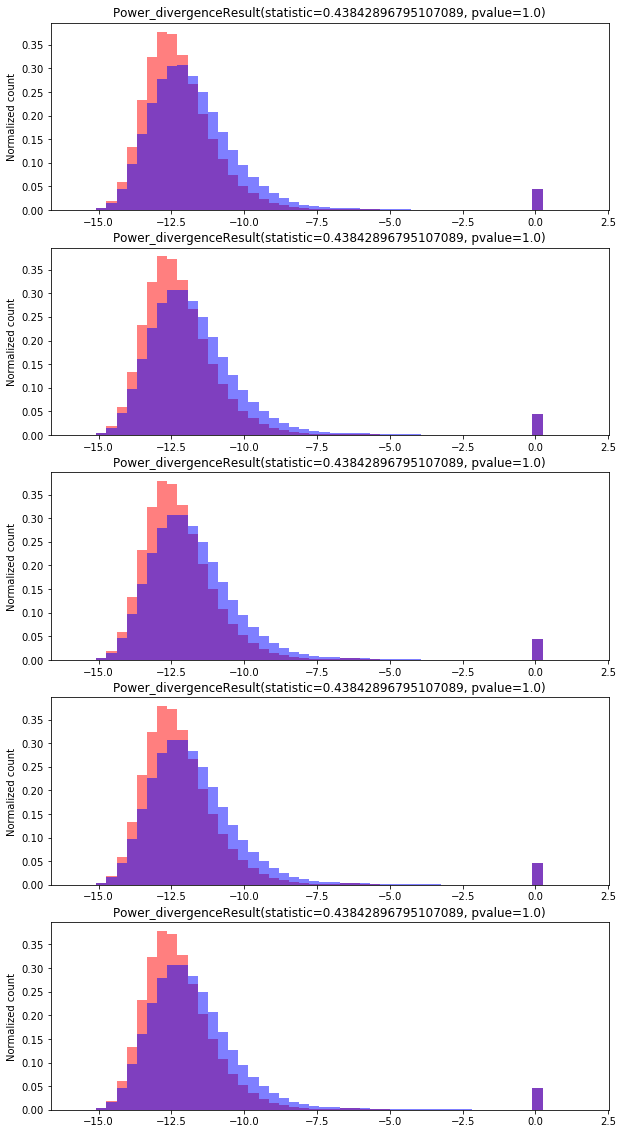

In [29]:
top_of_res = 2835
bottom_of_res = 5720
top_of_noise = 1000

f, ax = plt.subplots(5, 1, figsize = (10, 20))

start_sample = 0
end_sample = 11000

for i in range(5):
    
    data = fdata_frames[1].loc[(fdata_frames[1]!=0).any(axis=1)]
    
    noise = data.iloc[start_sample:end_sample, top_of_noise:top_of_res].as_matrix().flatten()
    signal = data.iloc[start_sample:end_sample, top_of_res:bottom_of_res].as_matrix().flatten()

    hist, bins, patches = ax[i].hist(np.nan_to_num(10*np.log10(noise)), bins = 50, alpha = 0.5, normed=True, color = 'red')
    ax[i].set_ylabel('Normalized count')
    #ax[i].set_xlabel('Amplitude (dB)')
    mhist, mbins, mpathces = ax[i].hist(np.nan_to_num(10*np.log10(signal)), bins = bins, alpha = 0.5, normed=True, color = 'blue')
    ax[i].set_title(chisquare(mhist, f_exp = hist))

plt.show()

In [1]:
data.rolling.apply()

def rolling_chi_square(df, noise_start, noise_stop, signal_start, signal_stop):
    noise = data.iloc[start_sample:end_sample, top_of_noise:top_of_res].as_matrix().flatten()
    signal = data.iloc[start_sample:end_sample, top_of_res:bottom_of_res].as_matrix().flatten()

    hist, bins, patches = ax[i].hist(np.nan_to_num(10*np.log10(noise)), bins = 50, alpha = 0.5, normed=True, color = 'red')
    ax[i].set_ylabel('Normalized count')
    #ax[i].set_xlabel('Amplitude (dB)')
    mhist, mbins = ax[i].hist(np.nan_to_num(10*np.log10(signal)), bins = bins, alpha = 0.5, normed=True, color = 'blue')
    ax[i].set_title(chisquare(mhist, f_exp = hist))


NameError: name 'data' is not defined

In [2]:
fig, ax = plt.subplots(figsize = (30, 30))
ax.imshow(10*np.log10(fdata[1]).T, aspect = 'auto')
plt.show()

NameError: name 'plt' is not defined

In [ ]:
data = fdata_frames[1].loc[(fdata_frames[1]!=0).any(axis=1)]



In [ ]:
top_of_res = 2835
top_of_noise = 1000

f, ax = plt.subplots(5, 2, figsize = (15, 20))

for i in range(5):
    
    n1, n2 = train_test_split(fdata[i][:, top_of_noise:top_of_res].T, test_size = 0.5, random_state = 50)
    t1, t2 = train_test_split(fdata[i][:, top_of_res:].T, test_size = 0.5, random_state = 50)
    
    hist, bins, patches = ax[i][0].hist(10*np.log10(n1.flatten()), bins = 20, alpha = 0.5, normed=True, color = 'red')
    ax[i][0].set_ylabel('Normalized count')
    #ax[i].set_xlabel('Amplitude (dB)')
    mhist, mbins, mpathces = ax[i][0].hist(10*np.log10(n2.flatten()), bins = bins, alpha = 0.5, normed=True, color = 'blue')
    ax[i][0].set_title(chisquare(mhist, f_exp = hist))
    
    hist, bins, patches = ax[i][1].hist(10*np.log10(t1.flatten()), bins = 20, alpha = 0.5, normed=True, color = 'red')
    ax[i][1].set_ylabel('Normalized count')
    #ax[i].set_xlabel('Amplitude (dB)')
    mhist, mbins, mpathces = ax[i][1].hist(10*np.log10(t2.flatten()), bins = bins, alpha = 0.5, normed=True, color = 'blue')
    ax[i][1].set_title(chisquare(mhist, f_exp = hist))
    
plt.show()

In [ ]:
top_of_res = 2835
top_of_noise = 1000

f, ax = plt.subplots(5, 2, figsize = (20, 20))

for i in range(5):
    noise = fdata[i][:, top_of_noise:top_of_res]
    signal = fdata[i][:, 4973]
    
    for j in range(2):
    
        if j == 0:
            hist, bins, patches = ax[i][j].hist(np.nan_to_num(10*np.log10(noise.flatten())), bins = 20, alpha = 0.5, normed=True, color = 'red')
            ax[i][j].set_ylabel('Normalized count')
            #ax[i].set_xlabel('Amplitude (dB)')
            mhist, mbins, mpathces = ax[i][j].hist(np.nan_to_num(10*np.log10(signal.flatten())), bins = bins, alpha = 0.5, normed=True, color = 'blue')
            ax[i][j].set_title(chisquare(mhist, f_exp = hist))
        else:
            hist, bins, patches = ax[i][j].hist(np.nan_to_num(10*np.log10(noise.flatten())), bins = 20, alpha = 0.5, normed=True, color = 'red')
            ax[i][j].set_ylabel('Normalized count')
            #ax[i].set_xlabel('Amplitude (dB)')
            mhist, mbins, mpathces = ax[i][j].hist(np.nan_to_num(10*np.log10(signal.flatten())), bins = bins, alpha = 0.5, normed=True, color = 'blue')
            ax[i][j].set_title(power_divergence(mhist, f_exp = hist, lambda_ = 'cressie-read'))

plt.show()

In [ ]:
top_of_res = 2835
top_of_noise = 1000

results = np.zeros((5, fdata[0][:, :].shape[1]))

for i in range(5):
    noise = fdata[i][:, top_of_noise:top_of_res]
    hist, bins = np.histogram(10*np.log10(noise.flatten()), bins = 20, normed=True)
    for n in range(fdata[i][:, :].shape[1]):
        signal = fdata[i][:, n]
        mhist, mbins = np.histogram(10*np.log10(signal.flatten()), bins = bins, normed=True)
        
        results[i, n] = chisquare(mhist, f_exp = hist)[0]

In [ ]:
fig, ax = plt.subplots(1, 5, figsize = (10, 10), sharey = True)

data = results[:, 250:]
fig.gca().invert_yaxis()
for i in range(5):
    ax[i].plot(data[i, :], np.arange(data.shape[1]) * 3.28084)
    if i == 0:
        ax[i].set_ylabel('Measured Depth (ft(KB))')
    ax[i].set_xlabel('Chi-Squared Value')
    ax[i].set_title('Band {0}'.format(i))

#fig.gca().invert_yaxis()
plt.show()

In [ ]:
results_nonzero = np.nan_to_num(results[:, 1000:])

In [ ]:
from scipy.stats import pearsonr

In [ ]:
print("     |  B0  |  B1  |  B2  |  B3  |  B4")
for i in range(5):
    f = []
    for j in range(5):
        f.append(pearsonr(results_nonzero[i, :], results_nonzero[j, :]))
        
    print("B{0} - | {1:.2f} | {2:.2f} | {3:.2f} | {4:.2f} | {5:.2f}".format(
            i, f[0][0], f[1][0], f[2][0], f[3][0], f[4][0]))

In [ ]:
data = results_nonzero[1:4, :].mean(axis = 0)
fig, ax = plt.subplots(figsize = (10, 10))
ax.plot(data[3000:], np.arange(data.shape[0])[3000:])
fig.gca().invert_yaxis()
plt.show()

In [ ]:
merged['b1'] = 0
merged['b2'] = 0
merged['b3'] = 0
merged['b4'] = 0

for n in range(4):
    merged.ix[:5707, 'b{0}'.format(n+1)] = results[n+1, :]

In [ ]:
r = merged.iloc[2700:5900]

perf_depths = merged.loc[merged['Pstring'] != 'Pnan-nan', 'MD'].values * 3.28084
perf_shots = merged.loc[merged['Pstring'] != 'Pnan-nan', 'Shots'].values
perf_labels = merged.loc[merged['Pstring'] != 'Pnan-nan', 'Pstring'].values

fig, ax = plt.subplots(figsize = (10, 100))
fig.gca().invert_yaxis()
fig.gca().yaxis.grid(b = True, which = 'major', color = 'black', linestyle = '-')
fig.gca().yaxis.grid(b = True, which = 'minor', color = 'black', linestyle = '--')

for i, group in r.groupby('Stage'):
    ax.scatter(group['Shots'], group['Measured Depth (mKB)'] * 3.28084)
    
for i, label in enumerate(perf_labels):
    ax.annotate(label, (perf_shots[i], perf_depths[i]))
    
ax.set_xlabel('Shots per Cluster')
ax.set_ylabel('Measured Depth (ftKB)')
ax2 = ax.twiny()
ax2.set_xlabel('Mean Chi-Squared - Bands 1:3')
ax2.plot(r.loc[:, ['b2', 'b1', 'b3']].mean(axis = 1), r['Measured Depth (mKB)'] * 3.28084)
ax2.set_xlim([0,100])
ax2.minorticks_on()
ax2.yaxis.grid(True)
ax2.grid(b = True, which = 'major', color = 'black', linestyle = '-')
ax2.grid(b = True, which = 'minor', color = 'black', linestyle = '--')

ax3 = ax.twiny()
ax3.plot(r.loc[:, ['b2', 'b1', 'b3']].mean(axis = 1), r['Measured Depth (mKB)'] * 3.28084, linestyle = '--')
ax3.set_xlim([100, 200])
ax3.xaxis.set_visible(False)
ax4 = ax.twiny()
ax4.plot(r.loc[:, ['b2', 'b1', 'b3']].mean(axis = 1), r['Measured Depth (mKB)'] * 3.28084, linestyle = '-')
ax4.set_xlim([200, 300])
ax4.xaxis.set_visible(False)


plt.show()

In [ ]:
r = merged

perf_depths = merged.loc[merged['Pstring'] != 'Pnan-nan', 'MD'].values
perf_shots = merged.loc[merged['Pstring'] != 'Pnan-nan', 'Shots'].values
perf_labels = merged.loc[merged['Pstring'] != 'Pnan-nan', 'Pstring'].values

fig = plt.figure(figsize = (10, 100))
gs1 = gridspec.GridSpec(1, 5)
ax1 = fig.add_subplot(gs1[:, :1])
ax4 = fig.add_subplot(gs1[:, 1:], sharey = ax1)

fig.gca().yaxis.grid(b = True, which = 'major', color = 'black', linestyle = '-')
fig.gca().yaxis.grid(b = True, which = 'minor', color = 'black', linestyle = '--')

for i, group in r.groupby('Stage'):
    ax1.scatter(group['Shots'], group['Measured Depth (mKB)'])
    
for i, label in enumerate(perf_labels):
    ax1.annotate(label, (perf_shots[i], perf_depths[i]))

    
ax2 = ax1.twiny()
ax2.plot(r.loc[:, ['b2', 'b1', 'b3']].mean(axis = 1), r['Measured Depth (mKB)'])
ax2.set_xlim([0,100])
ax2.minorticks_on()
ax2.yaxis.grid(True)
ax2.grid(b = True, which = 'major', color = 'black', linestyle = '-')
ax2.grid(b = True, which = 'minor', color = 'black', linestyle = '--')

ax3 = ax1.twiny()
ax3.plot(r.loc[:, ['b2', 'b1', 'b3']].mean(axis = 1), r['Measured Depth (mKB)'], linestyle = '--')
ax3.set_xlim([100, 200])
ax3.xaxis.set_visible(False)

image = pd.DataFrame(data = fdata[1].value, columns = merged.ix[:fdata[1].shape[1] - 1, 'Measured Depth (mKB)'])

ax4.imshow(10*np.log10(image).T, aspect = 'auto', extent=[0, len(image.index), image.columns[-1], image.columns[0]], cmap = 'viridis', vmin = -20, vmax = -5)

plt.show()

In [ ]:
ax = scatter_matrix(merged.loc[2750:, ['b1', 'b2', 'b3', 'b4']], alpha=0.5, figsize=(20, 20), diagonal='kde', grid='minor')
plt.show()

In [ ]:
merged.head()

In [ ]:
merged['ChiMean'] = merged.loc[:, ['b1', 'b2', 'b3']].mean(axis = 1)

In [ ]:
merged['ChiMeanNorm'] = normalize(merged['ChiMean'].fillna(0.0).values.reshape(1, -1), norm = 'max')[0]

In [ ]:
merged.to_csv(r'C:\Users\george.crowther\Documents\Python\Projects\rice_energy\data\{0}-{1}-Result.csv'.format(starttime.strftime('%Y-%m-%d %H%M%S'), endtime.strftime('%Y-%m-%d %H%M%S')))

In [ ]:
chisquare?

In [ ]:
from scipy.stats import power_divergence

In [ ]:
power_divergence?

In [ ]:
d = 2 * 0.0254
l = 4.40

circumference = np.pi * d
wrap_angle = 85
wrap_length = circumference / np.tan(np.radians(wrap_angle))
wrap_fibre_length = np.sqrt((circumference ** 2) + (wrap_length ** 2))
num_channels = (l / wrap_length) * wrap_fibre_length
print(wrap_length)
print(wrap_fibre_length)
print((l / wrap_length))
print(num_channels)

In [ ]:
d = 3 * 0.0254
l = 4.40

circumference = np.pi * d
wrap_angle = 89
wrap_length = circumference / np.tan(np.radians(wrap_angle))
wrap_fibre_length = np.sqrt((circumference ** 2) + (wrap_length ** 2))
num_channels = (l / wrap_length) * wrap_fibre_length
print(wrap_length)
print(wrap_fibre_length)
print((l / wrap_length))
print(num_channels)
print(l / num_channels)

In [ ]:
velocity = 3.0
deltav = 0.1

sos = 1400.0
channel_sos = sos * num_channels / l
channel_velocity = velocity * num_channels / l

ping = 20000
tfft = 256
sfft = int(num_channels)




In [ ]:
print(channel_sos)
print(channel_velocity)

print(l / 1400)

In [ ]:
(20000000 / 60) / 3600 / 24

In [ ]:
(10e12 / 70e06) / 3600